<a href="https://colab.research.google.com/github/sidmahurkar/SemEval-Humor/blob/master/semeval_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
PATH = '/content/drive/My Drive/semeval_humor/'

In [0]:
!wget https://www.cs.rochester.edu/u/nhossain/humicroedit/semeval-2020-task-7-data.zip

--2020-02-19 19:19:55--  https://www.cs.rochester.edu/u/nhossain/humicroedit/semeval-2020-task-7-data.zip
Resolving www.cs.rochester.edu (www.cs.rochester.edu)... 192.5.53.208
Connecting to www.cs.rochester.edu (www.cs.rochester.edu)|192.5.53.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 919538 (898K) [application/zip]
Saving to: ‘semeval-2020-task-7-data.zip’

semeval-2020-task-7 100%[===================>] 897.99K  1.70MB/s    in 0.5s    

2020-02-19 19:19:56 (1.70 MB/s) - ‘semeval-2020-task-7-data.zip’ saved [919538/919538]



In [0]:
!unzip semeval-2020-task-7-data.zip

Archive:  semeval-2020-task-7-data.zip
   creating: data/
   creating: data/task-1/
  inflating: data/task-1/.DS_Store   
  inflating: data/task-1/dev.csv     
  inflating: data/task-1/train.csv   
  inflating: data/.DS_Store          
   creating: data/task-2/
  inflating: data/task-2/.DS_Store   
  inflating: data/task-2/dev.csv     
  inflating: data/task-2/train.csv   


In [0]:
!pip install transformers

     |████████████████████████████████| 491kB 8.7MB/s 
     |████████████████████████████████| 3.8MB 21.0MB/s 
     |████████████████████████████████| 870kB 28.0MB/s 
     |████████████████████████████████| 1.0MB 60.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=080eb9dd7cbcb2dd4fec97b8d3ba48dc1c7fd7fa8427934f2d1272d81751fe86
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [0]:
# Reading dataset
import pandas as pd

def read_data(PATH):
  df = pd.read_csv(PATH)
  df.dropna(inplace = True)
  df.reset_index(inplace = True)
  print('Dataframe Loaded!')

  return df

In [0]:
data = read_data('./data/task-2/train.csv')
data.head()

Dataframe Loaded!


,index,id,original1,edit1,grades1,meanGrade1,original2,edit2,grades2,meanGrade2,label
0,0,10920-9866,""" Gene Cernan , Last <Astronaut/> on the Moon ...",Dancer,1113,1.2,""" Gene Cernan , Last Astronaut on the Moon , <...",impregnated,30001,0.8,1
1,1,3176-10722,""" I 'm done "" : Fed up with California , some ...",vagrants,1200,0.6,""" I 'm done "" : Fed up with <California/> , so...",pancakes,10110,0.6,0
2,2,3176-3702,""" I 'm done "" : Fed up with California , some ...",vagrants,1200,0.6,""" I 'm done "" : Fed up with <California/> , so...",life,2,0.4,1
3,3,10722-3702,""" I 'm done "" : Fed up with <California/> , so...",pancakes,10110,0.6,""" I 'm done "" : Fed up with <California/> , so...",life,2,0.4,1
4,4,12282-2083,""" Our expectations of what civic engagement lo...",imagine,0,0.0,""" Our expectations of what civic engagement <l...",smells,100220010,0.6,2


In [0]:
tdata = read_data('./data/task-2/dev.csv')
tdata.head()

Dataframe Loaded!


,index,id,original1,edit1,original2,edit2
0,0,61-5576,""" Nutella <riots/> "" erupt in France over disc...",brownies,""" Nutella <riots/> "" erupt in France over disc...",sales
1,1,61-11943,""" Nutella <riots/> "" erupt in France over disc...",brownies,""" Nutella riots "" erupt in France over discoun...",Bunnies
2,2,5576-11943,""" Nutella <riots/> "" erupt in France over disc...",sales,""" Nutella riots "" erupt in France over discoun...",Bunnies
3,3,12581-9120,$ 45 billion added to health care bill for opi...,party,$ 45 billion added to health care bill for opi...,Handouts
4,4,3605-11504,"' 400,000 <People/> ... Live In Hell On Earth ...",Goats,"' 400,000 People ... Live In Hell On Earth ' :...",Disinfecting


In [0]:
a = data['label'][1]
type(a)

numpy.int64

In [0]:
# For passing weights to Loss Function
num_0 = 0
num_1 = 0
num_2 = 0
total = 0

for i in range(len(data)):
  if data['label'][i] == 1:
    num_1+=1
  elif data['label'][i] == 0:
    num_0+=1
  elif data['label'][i] == 2:
    num_2+=1  

total = num_0 + num_1 + num_2
print("Number of '0' labels: ", num_0)
print("Number of '1' labels: ", num_1)
print("Number of '2' labels: ", num_2)
print(total)

Number of '0' labels:  999
Number of '1' labels:  4198
Number of '2' labels:  4184
9381


# Getting the two sentence Pair

In [0]:
def get_sentence_pair(sent_orig_1, edit_word_1, sent_orig_2, edit_word_2):

  sent_edit_1 = (sent_orig_1.split('<'))[0] + edit_word_1 + (sent_orig_1.split('<'))[1]
  sent_edit_2 = (sent_orig_2.split('<'))[0] + edit_word_2 + (sent_orig_2.split('<'))[1]

  return sent_edit_1, sent_edit_2

# DAtaset

In [0]:
import pandas as pd
import torch
import re
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import transformers


class baseline_dataset_task2(Dataset):
  def __init__(self, df, max_len, model_name):
    self.df = df
    self.max_len = max_len
    tokenizer_used = transformers.BertTokenizer
    self.tokenizer = tokenizer_used.from_pretrained(model_name)

    self.pad = self.tokenizer.pad_token_id
    self.cls = [self.tokenizer.cls_token_id]
    self.sep = [self.tokenizer.sep_token_id]

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    label = torch.tensor(self.df['label'][idx])

    sent_1, sent_2 = get_sentence_pair(self.df['original1'][idx], self.df['edit1'][idx], self.df['original2'][idx], self.df['edit2'][idx])

    sent_1_tokens = self.cls + self.tokenizer.encode(sent_1, add_special_tokens=False) + self.sep      
    sent_2_tokens = self.tokenizer.encode(sent_2, add_special_tokens=False) + self.sep

    token_type_ids = (torch.tensor([0]*len(sent_1_tokens) + [1]*(self.max_len-len(sent_1_tokens)))).long()
    #attention_mask = torch.tensor([1]*(len(sent_1_tokens)+len(sent_2_tokens)) + [0]*(self.max_len - len(sent_1_tokens) - len(sent_2_tokens)))
    #attention_mask = attention_mask.float()

    input_ids = torch.tensor(sent_1_tokens + sent_2_tokens)

    if len(input_ids)<self.max_len:
      attention_mask = torch.tensor([1]*input_ids.shape[0] + [0]*(self.max_len-input_ids.shape[0]))
      # attention_mask = torch.tensor([1]*(len(input_ids)) + [0]*(self.max_len - len(input_ids)) )
      input_ids = torch.cat((input_ids, (torch.ones(self.max_len-len(input_ids))*self.pad).long()))
    elif len(input_ids)>=self.max_len:
      input_ids = input_ids[:self.max_len]
      attention_mask = torch.tensor([1]*self.max_len)

    return (input_ids, token_type_ids, attention_mask, label)

# Code

In [0]:
import time
import numpy as np
import torch
from torch import nn
import transformers

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt
%matplotlib inline

seed_val = 1234
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = ('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


In [0]:
model_name = 'bert-base-uncased'
epochs = 7
lr = 1e-4
bs = 32
fname = 'baseline_task_2_'

# Loading DataLoaders

In [0]:
data = read_data('./data/task-2/train.csv')
train_df, valid_df = train_test_split(data, random_state = seed_val, test_size = 0.1)

test_df = read_data('./data/task-2/dev.csv')
test_df['label'] = [0]*len(test_df)

train_df.reset_index(inplace=True)
valid_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

#Datasets 
train_dset = baseline_dataset_task2(train_df, 512, model_name)
valid_dset = baseline_dataset_task2(valid_df, 512, model_name)
test_dset = baseline_dataset_task2(test_df, 512, model_name)

'''for i in range(len(train_dset)):
  input_ids, token_type_ids, attention_mask, label = train_dset[i]
  print(input_ids.shape, token_type_ids.shape, attention_mask.shape)'''

#DataLoaders
train_loader = DataLoader(train_dset, batch_size= bs, shuffle= True, num_workers=0)
val_loader = DataLoader(valid_dset, batch_size= bs, shuffle= False, num_workers=0)
test_loader = DataLoader(test_dset, batch_size= 1, shuffle= False, num_workers=0)

Dataframe Loaded!
Dataframe Loaded!


In [0]:
len(train_dset)

8442

In [0]:
b=0
for i in range(len(train_dset)):
  input_ids, token_type_ids, attention_mask, label = train_dset[i]
  print(input_ids.shape, token_type_ids.shape, attention_mask.shape, label.shape)
  print(label)
  b+=1
  if(b==5):
    break

torch.Size([512]) torch.Size([512]) torch.Size([512]) torch.Size([])
tensor(0)
torch.Size([512]) torch.Size([512]) torch.Size([512]) torch.Size([])
tensor(2)
torch.Size([512]) torch.Size([512]) torch.Size([512]) torch.Size([])
tensor(2)
torch.Size([512]) torch.Size([512]) torch.Size([512]) torch.Size([])
tensor(1)
torch.Size([512]) torch.Size([512]) torch.Size([512]) torch.Size([])
tensor(1)


In [0]:
a=0
for i in train_loader:
  print(i[3])
  print(i[3].shape)
  a+=1
  if(a==2):
    break

tensor([2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1, 1, 1, 2, 2, 1,
        1, 2, 2, 2, 1, 2, 1, 1])
torch.Size([32])
tensor([2, 2, 0, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 2, 2, 1, 2, 2, 2, 2, 1,
        1, 1, 1, 1, 1, 2, 0, 1])
torch.Size([32])


In [0]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

# Load Model

In [0]:
model = transformers.BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
model = model.to(device)

# FineTuning

In [0]:
for name, param in model.named_parameters():
  print(name)

bert.embeddings.word_embeddings.weight
bert.embeddings.position_embeddings.weight
bert.embeddings.token_type_embeddings.weight
bert.embeddings.LayerNorm.weight
bert.embeddings.LayerNorm.bias
bert.encoder.layer.0.attention.self.query.weight
bert.encoder.layer.0.attention.self.query.bias
bert.encoder.layer.0.attention.self.key.weight
bert.encoder.layer.0.attention.self.key.bias
bert.encoder.layer.0.attention.self.value.weight
bert.encoder.layer.0.attention.self.value.bias
bert.encoder.layer.0.attention.output.dense.weight
bert.encoder.layer.0.attention.output.dense.bias
bert.encoder.layer.0.attention.output.LayerNorm.weight
bert.encoder.layer.0.attention.output.LayerNorm.bias
bert.encoder.layer.0.intermediate.dense.weight
bert.encoder.layer.0.intermediate.dense.bias
bert.encoder.layer.0.output.dense.weight
bert.encoder.layer.0.output.dense.bias
bert.encoder.layer.0.output.LayerNorm.weight
bert.encoder.layer.0.output.LayerNorm.bias
bert.encoder.layer.1.attention.self.query.weight
bert.enc

In [0]:
for param in model.parameters():
  param.requires_grad = False
  # print("All Parametres Freezed")

for param in model.bert.pooler.parameters():
  param.requires_grad = True
  # print("Pooling layer param. unfreezed")
for param in model.classifier.parameters():
  param.requires_grad = True
  # print("classifier layer param. unfreezed")

for name, param in model.named_parameters():
  if ('layer.11' in name) | ('layer.10' in name):
  # if ('layer.11' in name) :
    param.requires_grad = True
    # print("layer11 and layer10 param. unfreezed")

# Optimizer and Loss Fucntoin

In [0]:
optimizer = transformers.AdamW(model.parameters(), lr= lr, eps=10-8)

# weights calculated using (num of total examples / num of total examples in a particular class)
weights = [9.39, 2.23, 2.24]
weights = torch.tensor(weights).cuda()
criterion = nn.CrossEntropyLoss(weight= weights)

# Trainaing and Validation Loop

In [0]:
print("Training Loop Started...\n")

train_loss = []
validation_loss = []
precision_list, f1_list, recall_list = [], [], []
max_f1 = -999
start_time = time.time()

model.train()
for epoch in range(epochs):
  running_loss = 0.0
  epoch_loss = 0.0
  for i,data in enumerate(train_loader):
    input_ids, token_type_ids, attention_mask, labels = data
    input_ids, token_type_ids, attention_mask, labels = input_ids.to(device), token_type_ids.to(device), attention_mask.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(input_ids=input_ids, 
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask,
                    labels= labels)
    _, logits = outputs[:2]
    # print("SHAPE OF THE LOGITS :",logits.shape)
    # logits.to(device)
    # loss = criterion(logits.reshape(-1), labels.float())
    loss = criterion(logits, labels)


    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    epoch_loss += loss.item()

    if i % 25 == 24:
      print('[%d, %5d] loss: %.3f time: %.3f' %
            (epoch + 1, i + 1, running_loss / 25, time.time()-start_time))
      running_loss = 0.0

  print("\nEpoch ", epoch+1, " Train Loss = ", epoch_loss/len(train_dset))
  train_loss.append(epoch_loss/len(train_dset))

  val_loss = 0.0
  model.eval()
  preds = []
  ground_truth = []
  with torch.no_grad():
    for i, data in enumerate(val_loader):
      input_ids, token_type_ids, attention_mask, labels = data
      input_ids, token_type_ids, attention_mask, labels = input_ids.to(device), token_type_ids.to(device), attention_mask.to(device), labels.to(device)

      outputs = model(input_ids=input_ids, 
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask,
                    labels=labels)
      _, logits = outputs[:2]

      # loss = criterion(logits.reshape(-1), labels.float())
      loss = criterion(logits, labels)



      val_loss += loss.item()

      # log_soft = nn.LogSoftmax()
      # predicted = log_soft(logits.reshape(-1))
      # predicted = log_soft(logits)

      # to get the max of the values from logits 
      top_p, top_class = logits.topk(1, dim=1)
      #copying the value of top_class into top_class_1 for calculating accuracy
      top_class_1 = top_class
      # Get where predicted and ground truth matches
      equals = top_class_1 == labels.view(*top_class.shape)

      top_class = top_class.squeeze()
      for pred in top_class:
        preds.append(pred.item())
      for label in labels:
        ground_truth.append(label.item())

      accuracy = torch.mean(equals.type(torch.FloatTensor))
      print("The accuracy for this batch is:", accuracy)
    
  print("EPOCH ", epoch + 1, "Validation Loss = ", val_loss/len(valid_dset))
  validation_loss.append(val_loss/len(valid_dset))
  model.train()

  preds = np.array(preds)
  ground_truth = np.array(ground_truth)
  prec, recall, f1_score, _ = precision_recall_fscore_support(ground_truth, preds, average='weighted')
  precision_list.append(prec)
  recall_list.append(recall)
  f1_list.append(f1_score)

  print("EPOCH ", epoch+1, " PREC = ", prec, " RECALL = ", recall, " F1 Score = ", f1_score, '\n')

  if f1_score > max_f1:
    print("Model optimized, saving weights!!")
    torch.save(model.state_dict(), './' + fname + '.pt')
    max_f1 = f1_score

Training Loop Started...

[1,    25] loss: 1.151 time: 37.550
[1,    50] loss: 1.171 time: 77.566
[1,    75] loss: 1.144 time: 116.082
[1,   100] loss: 1.167 time: 155.056
[1,   125] loss: 1.145 time: 193.852
[1,   150] loss: 1.151 time: 232.584
[1,   175] loss: 1.144 time: 271.613
[1,   200] loss: 1.141 time: 310.623
[1,   225] loss: 1.137 time: 349.649
[1,   250] loss: 1.120 time: 388.530

Epoch  1  Train Loss =  0.03583847086905755
The accuracy for this batch is: tensor(0.5000)
The accuracy for this batch is: tensor(0.4375)
The accuracy for this batch is: tensor(0.5938)
The accuracy for this batch is: tensor(0.3750)
The accuracy for this batch is: tensor(0.3750)
The accuracy for this batch is: tensor(0.2812)
The accuracy for this batch is: tensor(0.3750)
The accuracy for this batch is: tensor(0.5938)
The accuracy for this batch is: tensor(0.4688)
The accuracy for this batch is: tensor(0.5000)
The accuracy for this batch is: tensor(0.5000)
The accuracy for this batch is: tensor(0.437

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[2,    25] loss: 1.122 time: 485.259
[2,    50] loss: 1.133 time: 524.285
[2,    75] loss: 1.120 time: 563.149
[2,   100] loss: 1.107 time: 602.023
[2,   125] loss: 1.128 time: 640.947
[2,   150] loss: 1.114 time: 679.931
[2,   175] loss: 1.106 time: 718.949
[2,   200] loss: 1.106 time: 757.718
[2,   225] loss: 1.108 time: 796.731
[2,   250] loss: 1.111 time: 835.772

Epoch  2  Train Loss =  0.034903133975982215
The accuracy for this batch is: tensor(0.4062)
The accuracy for this batch is: tensor(0.4062)
The accuracy for this batch is: tensor(0.2500)
The accuracy for this batch is: tensor(0.4062)
The accuracy for this batch is: tensor(0.5000)
The accuracy for this batch is: tensor(0.4375)
The accuracy for this batch is: tensor(0.6250)
The accuracy for this batch is: tensor(0.4062)
The accuracy for this batch is: tensor(0.5000)
The accuracy for this batch is: tensor(0.4688)
The accuracy for this batch is: tensor(0.5000)
The accuracy for this batch is: tensor(0.4688)
The accuracy for thi

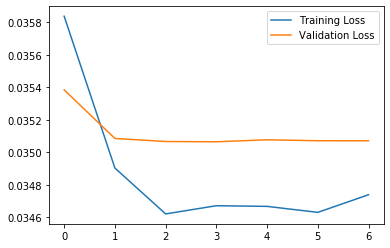

<Figure size 432x288 with 0 Axes>

In [0]:
fig = plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.show()
plt.savefig('./' + fname + 'loss.png', dpi= 400)

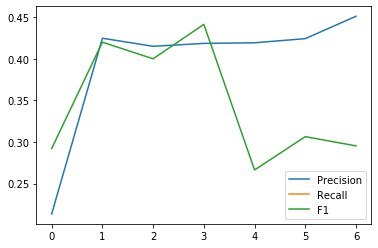

<Figure size 432x288 with 0 Axes>

In [0]:
fig = plt.figure()
plt.plot(precision_list, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(f1_list, label='F1')
plt.legend()
plt.show()
plt.savefig('./' + fname + 'metrics.png', dpi= 400)

In [0]:
# On Test Data
preds = []
with torch.no_grad():
  for i, data in enumerate(test_loader):
    input_ids, token_type_ids, attention_mask, labels = data
    input_ids, token_type_ids, attention_mask, labels = input_ids.to(device), token_type_ids.to(device), attention_mask.to(device), labels.to(device)

    outputs = model(input_ids=input_ids, 
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask,
                    labels=labels)
    _, logits = outputs[:2]
    print("SHAPE OF THE LOGITS :",logits.shape)


    # to get the max of the values from logits 
    top_p, top_class = logits.topk(1, dim=1)     
    print("SHAPE OF THE top_class before squeeze :",top_class.shape)

    # Get where predicted and ground truth matches
    # equals = top_class == labels.view(*top_class.shape)

    top_class = top_class.squeeze()
    print("SHAPE OF THE top_class after squeeze :",top_class.shape)

    # for pred in top_class:
    preds.append(top_class.item())
    
preds = np.array(preds)

Streaming output truncated to the last 5000 lines.
SHAPE OF THE top_class after squeeze : torch.Size([])
SHAPE OF THE LOGITS : torch.Size([1, 3])
SHAPE OF THE top_class before squeeze : torch.Size([1, 1])
SHAPE OF THE top_class after squeeze : torch.Size([])
SHAPE OF THE LOGITS : torch.Size([1, 3])
SHAPE OF THE top_class before squeeze : torch.Size([1, 1])
SHAPE OF THE top_class after squeeze : torch.Size([])
SHAPE OF THE LOGITS : torch.Size([1, 3])
SHAPE OF THE top_class before squeeze : torch.Size([1, 1])
SHAPE OF THE top_class after squeeze : torch.Size([])
SHAPE OF THE LOGITS : torch.Size([1, 3])
SHAPE OF THE top_class before squeeze : torch.Size([1, 1])
SHAPE OF THE top_class after squeeze : torch.Size([])
SHAPE OF THE LOGITS : torch.Size([1, 3])
SHAPE OF THE top_class before squeeze : torch.Size([1, 1])
SHAPE OF THE top_class after squeeze : torch.Size([])
SHAPE OF THE LOGITS : torch.Size([1, 3])
SHAPE OF THE top_class before squeeze : torch.Size([1, 1])
SHAPE OF THE top_class af

In [0]:
print(preds)

[2 2 1 ... 1 0 2]


In [0]:
submission_df = pd.DataFrame(columns=['id','pred'])
submission_df['id'] = test_df['id']
submission_df['pred'] = preds
assert(len(submission_df) == len(test_df))
submission_df.head()

,id,pred
0,61-5576,2
1,61-11943,2
2,5576-11943,1
3,12581-9120,0
4,3605-11504,0


In [0]:
submission_df.to_csv('task-2-output-layer11-baseline2.csv', index=False)
from google.colab import files
files.download('task-2-output-layer11-baseline2.csv')

In [0]:
import torch
bh = torch.FloatTensor([1.0,2.0])

In [0]:
hn = bh.long()

In [0]:
hn

tensor([1, 2])